In [2]:
import gpflow
import numpy as np
import matplotlib
from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

In [3]:
def gen_data(x):
    y = x * np.sin(x*10) + 1 
    y += np.random.uniform(0, 0.1, size=(len(y)))
    return y

In [4]:
# generate some fake data
x = np.linspace(0, 1, 50)
x = x[::6]
y = gen_data(x)

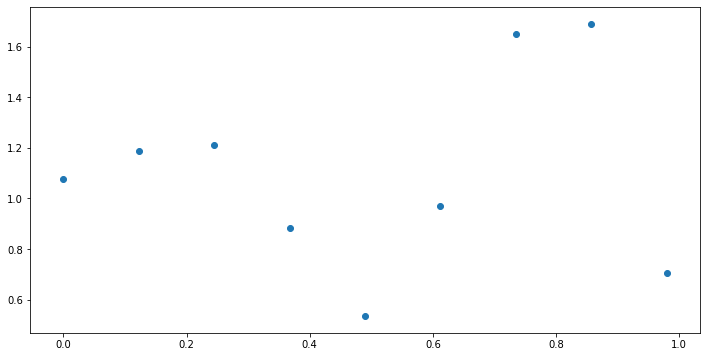

In [5]:
plt.figure()
plt.scatter(x, y)

In [6]:
X = x.reshape(-1, 1)
Y = y.reshape(-1, 1)

In [7]:
# choose kernel

In [22]:
k = gpflow.kernels.Matern52()
# k = gpflow.kernels.SquaredExponential()
# k = gpflow.kernels.RBF()

In [23]:
print_summary(k)

name                  class      transform    trainable    shape    dtype      value
--------------------  ---------  -----------  -----------  -------  -------  -------
Matern52.variance     Parameter  Softplus     True         ()       float64        1
Matern52.lengthscale  Parameter  Softplus     True         ()       float64        1


In [24]:
meanf = gpflow.mean_functions.Constant(1)

In [25]:
# constuct a model

In [26]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=meanf)
# m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

In [27]:
# m.likelihood.variance.assign(0.000771477)
# m.kernel.lengthscale.assign(0.34111)
m.kernel.lengthscale.assign(np.mean(np.diff(x))) # average distance between points

In [28]:
print_summary(m)

name                     class      transform    trainable    shape    dtype       value
-----------------------  ---------  -----------  -----------  -------  -------  --------
GPR.mean_function.c      Parameter               True         ()       float64  1
GPR.kernel.variance      Parameter  Softplus     True         ()       float64  1
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64  0.122449
GPR.likelihood.variance  Parameter  Softplus     True         ()       float64  1


In [29]:
# optimise

In [30]:
opt = gpflow.optimizers.Scipy()

In [31]:
def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100)
                       )

In [32]:
print_summary(m)

name                     class      transform    trainable    shape    dtype          value
-----------------------  ---------  -----------  -----------  -------  -------  -----------
GPR.mean_function.c      Parameter               True         ()       float64  1.04806
GPR.kernel.variance      Parameter  Softplus     True         ()       float64  0.166936
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64  0.126213
GPR.likelihood.variance  Parameter  Softplus     True         ()       float64  3.37203e-08


In [33]:
# predict

In [34]:
xx = np.linspace(0, 1, 100)

yy = gen_data(xx)

xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)





mean, var = m.predict_f(xx)

samples = m.predict_f_samples(xx, 10)

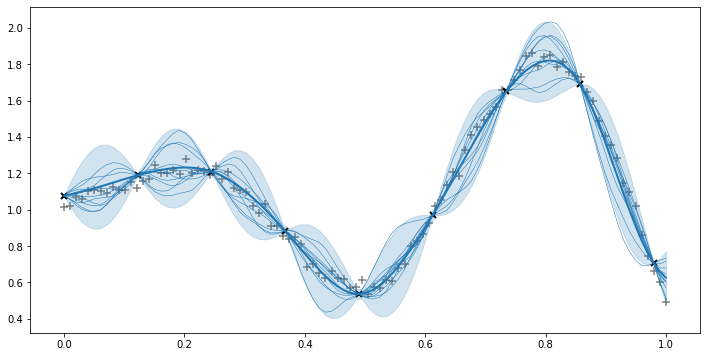

In [35]:
plt.figure()
plt.plot(X, Y, 'kx', mew=2)

plt.scatter(xx, yy, s=50, marker="+", c='k', alpha=0.5)

plt.plot(xx, mean, 'C0', lw=2)

plt.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color='C0', alpha=0.2
)

plt.plot(xx, samples[:,:,0].numpy().T, 'C0', lw=0.5);